Week 10: Neural Nets Regression

5.1 Noisy Lennard-Jones-Gauss data

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Defining the Lennard-Jones potential without noise

def LJ_pot(r,eps=1,sigma=1):
    V = 4*eps*((sigma/r)**12-(sigma/r)**6)
    return V


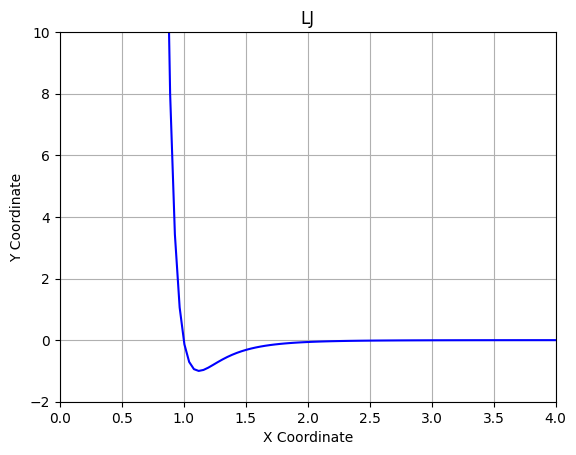

In [9]:
# Plot the LJ pot without noise

xs = np.linspace(0.2,4,100)
ys = LJ_pot(xs,1,1)

plt.plot(xs, ys, color='blue')

# Labeling the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('LJ')
plt.xlim(0,4)
plt.ylim(-2,10)
plt.grid(True)

# Show the plot
plt.show()

In [16]:
def noisy_LJ(xs, noise_level, seed=None):
    if seed is not None:
        np.random.seed(seed)
    ys = LJ_pot(xs)
    noise = noise_level * np.random.uniform(-1, 1, size=xs.shape)
    return ys + noise

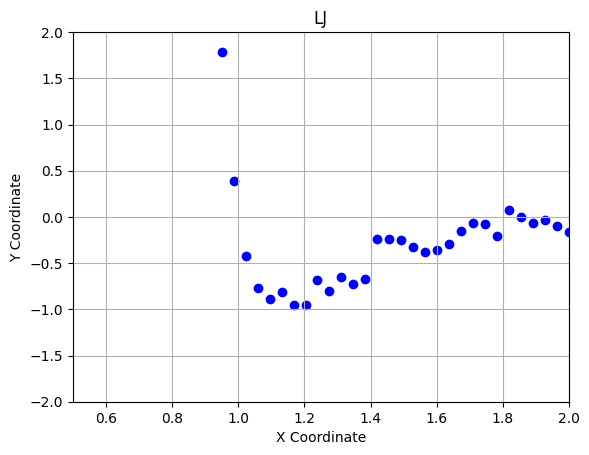

In [26]:
# Plotting the noise data

xs = np.linspace(0.95, 2, 30)
ys = noisy_LJ(xs, 0.2)

plt.scatter(xs, ys, color='blue')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('LJ')
plt.xlim(0.5, 2)
plt.ylim(-2, 2)
plt.grid(True)

plt.show()


5.2 Deep neural network fit

Fit with some deep neural networks. Investigate issues like:

- Role of network size (and architecture). Vary amount and size of hidden layers.

- Role of activation. Try something else but ReLU.

- Reproducibility. Does it give the same every time?

- Regularization. Do you see overfitting?

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

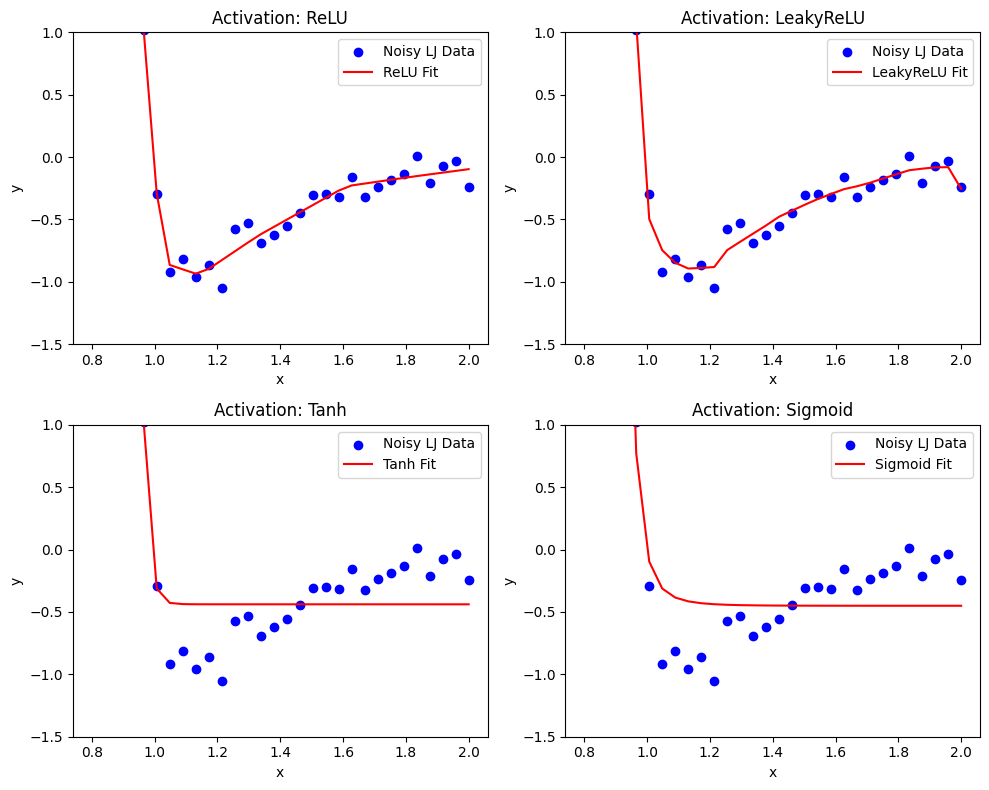

In [ ]:
class LJNet(nn.Module):
    def __init__(self, layer_sizes, activation_func):
        """
        Initialize a flexible feedforward network.
        
        Args:
        - layer_sizes (list): A list defining the number of neurons in each layer. 
                              For example, [1, 64, 128, 64, 1] defines a network with:
                              - Input layer (1 neuron)
                              - 3 hidden layers with 64, 128, and 64 neurons
                              - Output layer (1 neuron)
        - activation_func (callable): Activation function to use in the network.
        """
        super(LJNet, self).__init__()
        
        self.layers = nn.ModuleList()
        self.activation = activation_func
        
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
    
    def forward(self, x):
        for layer in self.layers[:-1]:  # Apply activation after all but the last layer
            x = self.activation(layer(x))
        x = self.layers[-1](x)  # Linear output for the final layer
        return x


# Training function
def train_model(x_train, y_train, activation_func, architecture, epochs=1000, lr=0.01):
    model = LJNet(architecture, activation_func)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions = model(x_train).numpy()
    return predictions

# Prepare data
xs = np.linspace(0.8, 2, 30)
ys = noisy_LJ(xs, 0.2, seed=42)
x_train = torch.tensor(xs, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(ys, dtype=torch.float32).view(-1, 1)

# Define activation functions
activation_functions = {
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(),
    "Tanh": nn.Tanh(),
    "Sigmoid": nn.Sigmoid()
}

architectures = [1, 32, 64, 32, 1],  # Wider network


# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

# Train and plot for each activation function
for i, (name, activation_func) in enumerate(activation_functions.items()):
    predictions = train_model(x_train, y_train, activation_func=activation_func, architecture=architectures[0])
    axes[i].scatter(xs, ys, label='Noisy LJ Data', color='blue')
    axes[i].plot(xs, predictions, label=f'{name} Fit', color='red')
    axes[i].set_title(f'Activation: {name}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_ylim(-1.5, 1)
    axes[i].legend()

plt.tight_layout()
plt.show()

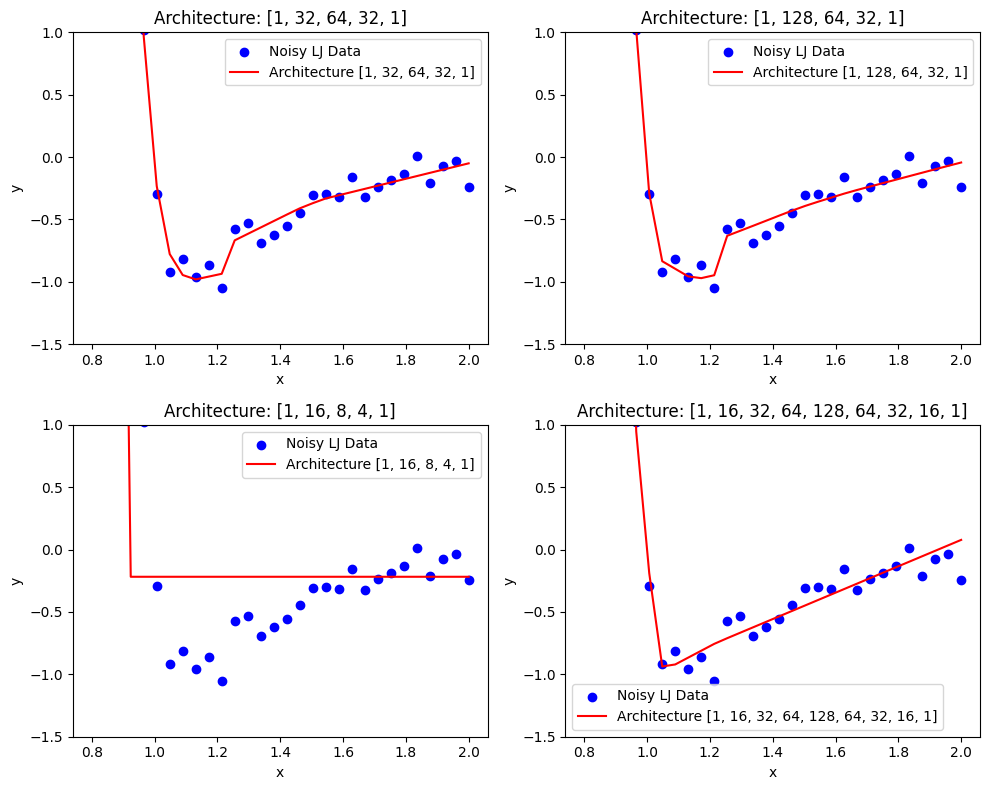

In [89]:
architectures = [
    [1, 32, 64, 32, 1],  # Wider network
    [1, 128, 64, 32, 1],  # Deeper network
    [1, 16, 8, 4, 1],     # Narrower network
    [1,16,32,64,128,64,32,16,1], 
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

activation_func = nn.ReLU() 

for i, architecture in enumerate(architectures):  # Use the architectures list directly
    predictions = train_model(x_train, y_train, activation_func=activation_func, architecture=architecture)
    axes[i].scatter(xs, ys, label='Noisy LJ Data', color='blue')
    axes[i].plot(xs, predictions, label=f'Architecture {architecture}', color='red')
    axes[i].set_title(f'Architecture: {architecture}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_ylim(-1.5, 1)
    axes[i].legend()

plt.tight_layout()
plt.show()


Exercise 52

6.1 overfitting

Make some (x,y)-data with noise for a y lineraly dependent on x.

In [27]:
w = 1
b = 0.5
xs_train = torch.rand(32) * 6 - 2
ys_train = w * xs_train + b + 0.5 * torch.randn(32)

Make two different PyTorch models:

1) One which knows about the underlying functional form (y = w * x + b) with learnable parameters w and b.
2) One that does not know about the linear form, but tries to fit many adjustable parameters (neural network).

In [ ]:
# The linear model knows that the underlying function is on a linear form. 
# It tries to find the parameters w and b in the function y = w * x + b.

class LinModel(torch.nn.Module):
    def __init__(self,A=1, b=1):
        super().__init__()
        self.A = torch.nn.Parameter(torch.tensor(float(A)))
        self.b = torch.nn.Parameter(torch.tensor(float(b)))

    def forward(self, x): 
        return self.A * x + self.b
    
A = 1
b = 0.5

model = LinModel(A=A, b=b)
model(1)

for parameter in model.parameters():
    print(parameter)

for name, parameter in model.named_parameters():
    print(name, '=', parameter.data.item())

steps = 10000

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for step in range(steps):
    y_pred = model(xs_train)
    loss = torch.mean((y_pred - ys_train) ** 2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f'Step {step}, Loss: {loss.item()}')

for name, parameter in model.named_parameters():
    print(name, '=', parameter.data.item())  
    if name == 'layers.0.weight':  
        A = parameter.data.item()
    elif name == 'layers.0.bias':  
        b = parameter.data.item()

Parameter containing:
tensor(1., requires_grad=True)
Parameter containing:
tensor(0.5000, requires_grad=True)
A = 1.0
b = 0.5
Step 0, Loss: 0.3248436748981476
Step 500, Loss: 0.2961801290512085
Step 1000, Loss: 0.2932985723018646
Step 1500, Loss: 0.29249534010887146
Step 2000, Loss: 0.29227134585380554
Step 2500, Loss: 0.29220885038375854
Step 3000, Loss: 0.29219141602516174
Step 3500, Loss: 0.29218658804893494
Step 4000, Loss: 0.2921851873397827
Step 4500, Loss: 0.29218482971191406
Step 5000, Loss: 0.2921847701072693
Step 5500, Loss: 0.2921847105026245
Step 6000, Loss: 0.2921847403049469
Step 6500, Loss: 0.2921847105026245
Step 7000, Loss: 0.2921847105026245
Step 7500, Loss: 0.29218465089797974
Step 8000, Loss: 0.29218465089797974
Step 8500, Loss: 0.29218465089797974
Step 9000, Loss: 0.29218465089797974
Step 9500, Loss: 0.29218465089797974
A = 1.1036158800125122
b = 0.3752986490726471


Create a plot of the linear model fit.

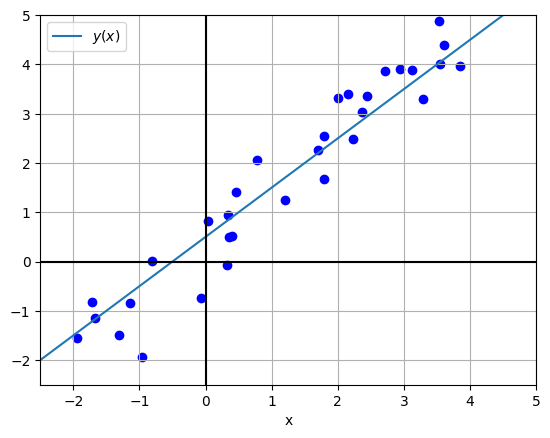

In [33]:
def lin_func(x,A,b):
    return A*x+b

fig, ax = plt.subplots()
xs = torch.linspace(-10, 10, 100, requires_grad=True)
ys = lin_func(xs,A,b)
yps = torch.autograd.grad(ys, xs, grad_outputs=torch.ones_like(xs))[0]

with torch.no_grad():
    ax.plot(xs, ys, label='$y(x)$')  # No conversion to numpy

ax.set_xlabel("x")
ax.grid(True)
ax.axhline(0, color='k')
ax.axvline(0, color='k')
ax.set_xlim([-2.5, 5])  # Set the y-axis limits
ax.set_ylim([-2.5, 5])  # Set the y-axis limits
ax.legend()
plt.scatter(xs_train,ys_train, color='blue', label='Data points')
plt.show()  # Display the plot

This seems to be a very good linear fit of the data :)

Next we make a more complicated neural network that does not know about the linear form. It just has many adjustable parameters. E.g. a deep neural net composed of 
- an input 1x8-layer with ReLU
- two hidden 8x8-layers each with ReLU
- an output 8x1-layer. 

In [43]:
# Reshape xs_train and ys_train to match the input format for the network
xs_train = xs_train.view(-1, 1)
ys_train = ys_train.view(-1, 1)

# The model DOES NOT KNOW about the form (i.e. that it's linear)
class UniNet(nn.Module):
    def __init__(self, layer_sizes, activation_func):
        super(UniNet, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation_func
        
        # Create linear layers based on layer_sizes
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)  # Linear output for the last layer
        return x

# Training function
def train_model(x_train, y_train, activation_func, architecture, epochs=10000, lr=0.01):
    model = UniNet(architecture, activation_func)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0 or epoch == epochs - 1:
            print(f"Step {epoch}, Loss_: {loss.item()}")

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions = model(x_train).numpy()
    return predictions

# defining architecture and activation function
architecture = [1, 8, 8, 8, 1]
activation_func = nn.ReLU()

# training the model
predictions = train_model(xs_train, ys_train, activation_func, architecture)

Step 0, Loss_: 8.496211051940918
Step 500, Loss_: 0.2411578744649887
Step 1000, Loss_: 0.23831257224082947
Step 1500, Loss_: 0.23644062876701355
Step 2000, Loss_: 0.23361195623874664
Step 2500, Loss_: 0.22899594902992249
Step 3000, Loss_: 0.2211892306804657
Step 3500, Loss_: 0.20626568794250488
Step 4000, Loss_: 0.2045658975839615
Step 4500, Loss_: 0.20428228378295898
Step 5000, Loss_: 0.20424140989780426
Step 5500, Loss_: 0.20442703366279602
Step 6000, Loss_: 0.20419786870479584
Step 6500, Loss_: 0.20419718325138092
Step 7000, Loss_: 0.20419375598430634
Step 7500, Loss_: 0.20419001579284668
Step 8000, Loss_: 0.2042052000761032
Step 8500, Loss_: 0.2042093127965927
Step 9000, Loss_: 0.20422914624214172
Step 9500, Loss_: 0.20420685410499573
Step 9999, Loss_: 0.20419052243232727


Compared to the LinModel which ended up on loss=0.29, the UniModel has a lower loss at the end of training. But lower loss value may indicate overfitting.

Plotting the fit from the UniNet model.

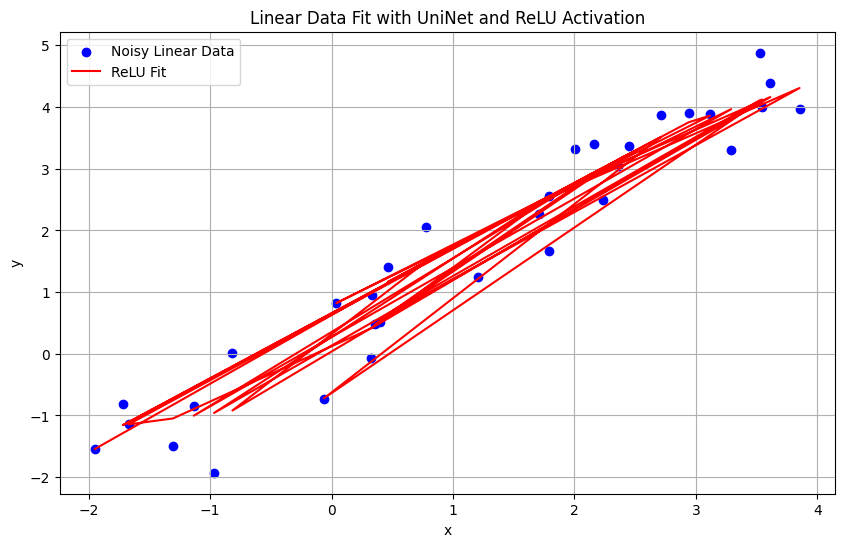

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(xs_train.detach().numpy(), ys_train.detach().numpy(), label='Noisy Linear Data', color='blue')
plt.plot(xs_train.detach().numpy(), predictions, label='ReLU Fit', color='red')
plt.title('Linear Data Fit with UniNet and ReLU Activation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


If this is indeed done correctly, the above plot shows an extremely overfitted fit which we might expect.

6.2 Regularization

Investigate the effect of adding L2 regularization of the parameters of the deep neural network.

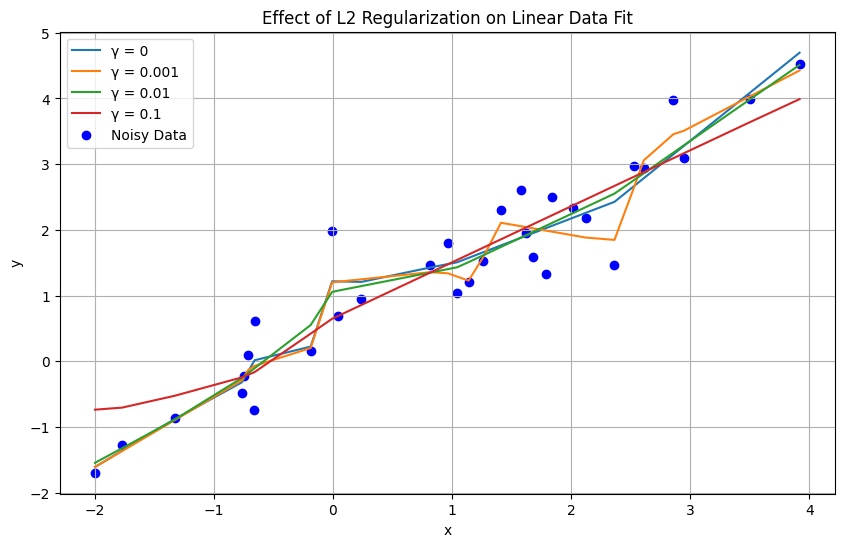

γ = 0 | Average Loss: 0.1976 ± 0.0062
γ = 0.001 | Average Loss: 0.1706 ± 0.0387
γ = 0.01 | Average Loss: 0.2041 ± 0.0060
γ = 0.1 | Average Loss: 0.2995 ± 0.0045


In [103]:
# Training function with L2 regularization
def train_model(x_train, y_train, activation_func, architecture, epochs, lr, gamma, num_runs=5):
    losses = []
    best_model = None
    best_loss = float('inf')
    
    for run in range(num_runs):
        model = UniNet(architecture, activation_func)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=gamma)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        final_loss = criterion(model(x_train), y_train).item()
        losses.append(final_loss)
        
        # Save the best model for this regularization level
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
    
    return best_model, losses

# Define the hyperparameters
epochs = 1000
learning_rate = 0.01
architecture = [1, 8, 8, 8, 1]
activation_func = nn.ReLU()
gamma_values = [0, 0.001, 0.01, 0.1]  # Different regularization strengths
num_runs = 5  # Number of runs to find the best model

# Train models for each regularization level
results = {}
for gamma in gamma_values:
    best_model, losses = train_model(xs_train, ys_train, activation_func, architecture, epochs, learning_rate, gamma, num_runs)
    results[gamma] = (best_model, losses)

# Plotting the results
plt.figure(figsize=(10, 6))

for gamma, (model, losses) in results.items():
    # Sort xs_train for smooth plotting
    sorted_indices = torch.argsort(xs_train, dim=0).squeeze()
    xs_train_sorted = xs_train[sorted_indices]  # Leave as a tensor
    ys_train_sorted = ys_train[sorted_indices].detach().numpy()

    # Generate predictions
    with torch.no_grad():
        predictions = model(xs_train_sorted).numpy()  # Convert to numpy after getting the predictions

    
    # Plot the predictions
    plt.plot(xs_train_sorted, predictions, label=f'γ = {gamma}')

# Scatter the original noisy data
plt.scatter(xs_train, ys_train, label='Noisy Data', color='blue')
plt.title('Effect of L2 Regularization on Linear Data Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Print average losses for each gamma
for gamma, (_, losses) in results.items():
    print(f'γ = {gamma} | Average Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}')


Exercise 53

7.1 Early stopping

The below data is given in the exercise

In [45]:
xs_train, ys_train = (
    torch.tensor([-3.5185,  4.7913, -5.7294,  6.8313, -6.1949, -2.8359,  3.5770, -9.7352,
               8.7236, -7.6444, -1.1604, -9.2950, -1.8292, -6.7322, -9.0877,  2.2723,
               2.7528,  5.6493, -5.1721,  7.4619,  2.5825,  6.7389, -3.8990, -5.9992,
              -4.8179, -0.1513,  6.4030, -1.3305, -2.6794, -9.2903, -6.6771,  9.1123,
              -6.6671, -5.1416, -6.7792,  6.6271,  2.0327, -2.4105,  0.2440,  7.1406]),
    torch.tensor([ -5.3765,  -9.0848,   2.1590,  -5.8315,   0.5031,  -3.8388,  -6.5292,
                9.6496,  -1.1439,   5.5176,  -8.8955,   4.3279,  -1.9723,   3.8308,
                6.4774,  -5.0248,  -7.7662,  -3.7932,  -1.8295,  -3.4870,  -6.7717,
               -4.3586,  -1.6717,   0.7881,  -0.4866,  -7.9941,  -8.7333,  -5.5161,
               -4.7155,   8.2325,  -1.7633,   2.4318,   1.8717,   1.8029,   2.2103,
               -4.0772,  -7.6173,  -3.6258, -10.3260,  -4.2308]))
xs_validation, ys_validation = (
    torch.tensor([-9.0973, -8.9917,  5.1596,  9.4471,  8.3714]),
    torch.tensor([ 8.7651,  5.7321, -5.7455, -0.1567, -3.6792]))
xs_test, ys_test = (
    torch.tensor([-9.9859, -1.1808, -3.3172,  7.6878,  7.2361]),
    torch.tensor([ 9.4506, -3.8572, -5.1936, -3.7723, -2.0726]))

7.2 Plot the data

Wrap your data as PyTorch Dataset's and let them be handled by PyTorch DataLoader's. Plot the three datasets with loops.

In [46]:
from torch.utils.data import TensorDataset, DataLoader

# Training data
train_dataset = TensorDataset(xs_train.view(-1, 1), ys_train.view(-1, 1))
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

# Validation data
validation_dataset = TensorDataset(xs_validation.view(-1, 1), ys_validation.view(-1, 1))
validation_loader = DataLoader(dataset=validation_dataset, batch_size=8, shuffle=False)

# Test data
test_dataset = TensorDataset(xs_test.view(-1, 1), ys_test.view(-1, 1))
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

# Iterating over the training data
for batch_features, batch_labels in train_loader:
    print("Features:", batch_features)
    print("Labels:", batch_labels)
    break  # Remove this break to iterate over the entire dataset

Features: tensor([[-2.8359],
        [-0.1513],
        [ 6.6271],
        [ 2.2723],
        [-3.8990],
        [ 0.2440],
        [-9.2950],
        [-5.1416]])
Labels: tensor([[ -3.8388],
        [ -7.9941],
        [ -4.0772],
        [ -5.0248],
        [ -1.6717],
        [-10.3260],
        [  4.3279],
        [  1.8029]])


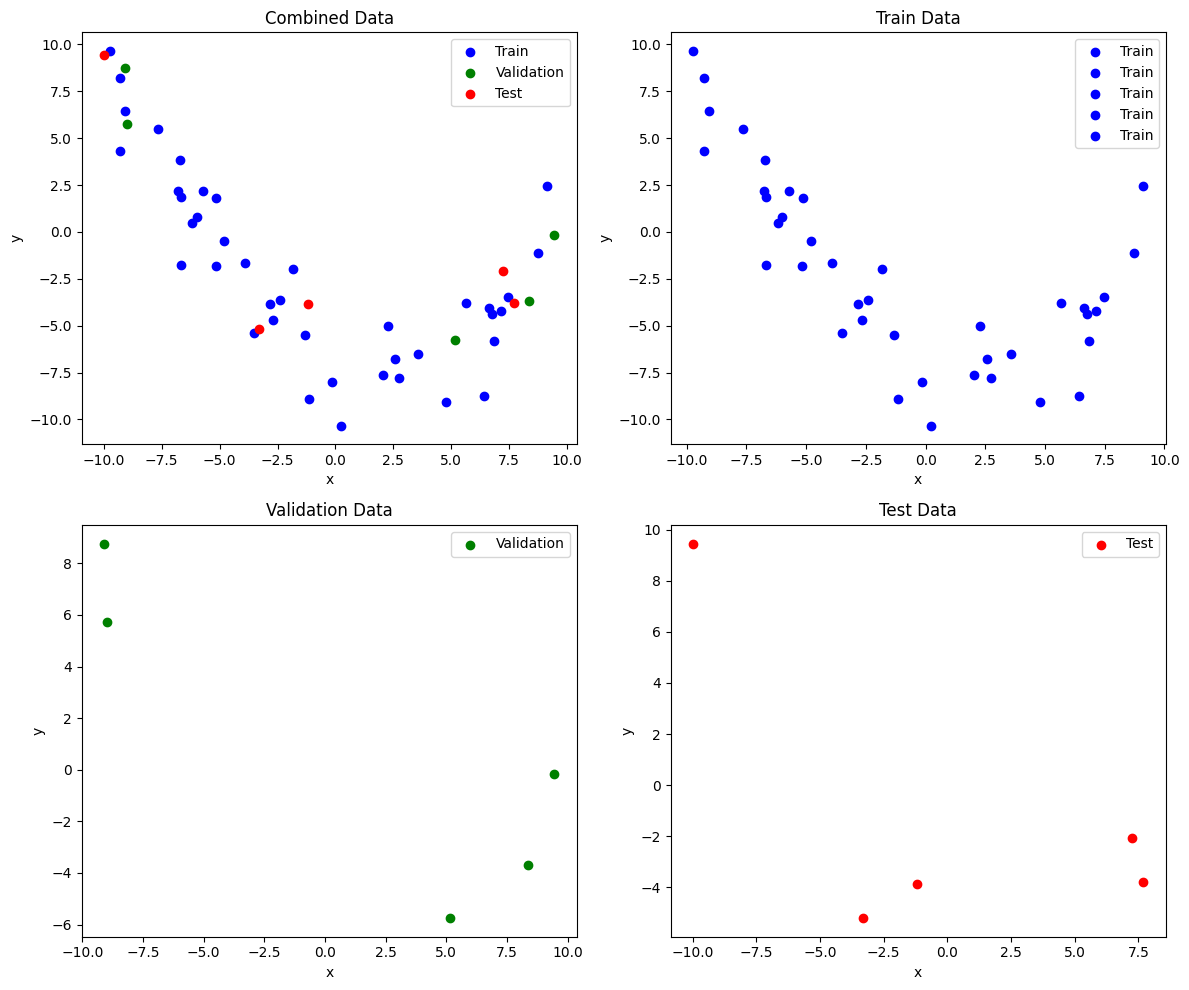

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily index subplots

# Define colors for each dataset
colors = {"train": "blue", "validation": "green", "test": "red"}

# Plot combined data in the first subplot
for loader, label, color in zip(
    [train_loader, validation_loader, test_loader], 
    ["Train", "Validation", "Test"], 
    [colors["train"], colors["validation"], colors["test"]]
):
    for batch_features, batch_labels in loader:
        axes[0].scatter(batch_features.numpy(), batch_labels.numpy(), color=color, label=label)

# Combined plot
axes[0].set_title("Combined Data")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
handles, labels = axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[0].legend(by_label.values(), by_label.keys())

# Remaining subplots
for idx, (loader, label, color) in enumerate(
    zip([train_loader, validation_loader, test_loader], ["Train", "Validation", "Test"], [colors["train"], colors["validation"], colors["test"]])
):
    for batch_features, batch_labels in loader:
        axes[idx + 1].scatter(batch_features.numpy(), batch_labels.numpy(), color=color, label=label)
    axes[idx + 1].set_title(f"{label} Data")
    axes[idx + 1].set_xlabel("x")
    axes[idx + 1].set_ylabel("y")
    axes[idx + 1].legend()

plt.tight_layout()
plt.show()



7.3 Early stopping

Implement early stopping and plot the training and validation errors.

In [72]:
# helper class implementing early stopping

class EarlyStopping:
    def __init__(self, patience=5):
        # patience (int): How many epochs to wait after last time validation loss improved.
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [73]:
early_stopping = EarlyStopping(patience=5)

loss_fn = nn.MSELoss()

# Training loop with early stopping
num_epochs = 100  # Maximum number of epochs
for epoch in range(num_epochs):
    # Training step
    model.train()
    train_loss = 0.0
    for batch_of_data in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_of_data[0])
        loss = loss_fn(outputs, batch_of_data[1])
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            train_loss += loss.item() * batch_of_data[0].size(0)
    train_loss /= len(train_loader.dataset)

    # Validation step
    model.eval()
    val_loss = 0.0
    for batch_of_data in validation_loader:
        with torch.no_grad():
            outputs = model(batch_of_data[0])
            val_loss += loss_fn(outputs, batch_of_data[1]).item() * batch_of_data[0].size(0)
    val_loss /= len(validation_loader.dataset)

    # Print losses
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

Epoch 1, Train Loss: 3.7318, Validation Loss: 1.9203
Epoch 2, Train Loss: 3.6764, Validation Loss: 1.7968
Epoch 3, Train Loss: 3.7397, Validation Loss: 2.2008
Epoch 4, Train Loss: 3.7050, Validation Loss: 1.9463
Epoch 5, Train Loss: 3.7052, Validation Loss: 1.9386
Epoch 6, Train Loss: 3.6724, Validation Loss: 1.8615
Epoch 7, Train Loss: 3.6976, Validation Loss: 2.0239
Early stopping triggered.


Testing it out with a simple model

Epoch 1/10000, Train Loss: 26.6211, Validation Loss: 28.4535
Epoch 2/10000, Train Loss: 24.7598, Validation Loss: 25.9905
Epoch 3/10000, Train Loss: 23.0261, Validation Loss: 25.0642
Epoch 4/10000, Train Loss: 22.7545, Validation Loss: 24.7148
Epoch 5/10000, Train Loss: 21.6972, Validation Loss: 23.2032
Epoch 6/10000, Train Loss: 21.4019, Validation Loss: 22.4790
Epoch 7/10000, Train Loss: 21.0426, Validation Loss: 20.1282
Epoch 8/10000, Train Loss: 20.5759, Validation Loss: 18.9642
Epoch 9/10000, Train Loss: 20.2581, Validation Loss: 17.6970
Epoch 10/10000, Train Loss: 19.9990, Validation Loss: 16.7825
Epoch 11/10000, Train Loss: 19.7313, Validation Loss: 16.6815
Epoch 12/10000, Train Loss: 19.3337, Validation Loss: 16.6366
Epoch 13/10000, Train Loss: 19.0525, Validation Loss: 16.8821
Epoch 14/10000, Train Loss: 18.7955, Validation Loss: 16.4308
Epoch 15/10000, Train Loss: 18.4342, Validation Loss: 16.3585
Epoch 16/10000, Train Loss: 18.2948, Validation Loss: 17.1356
Epoch 17/10000, T

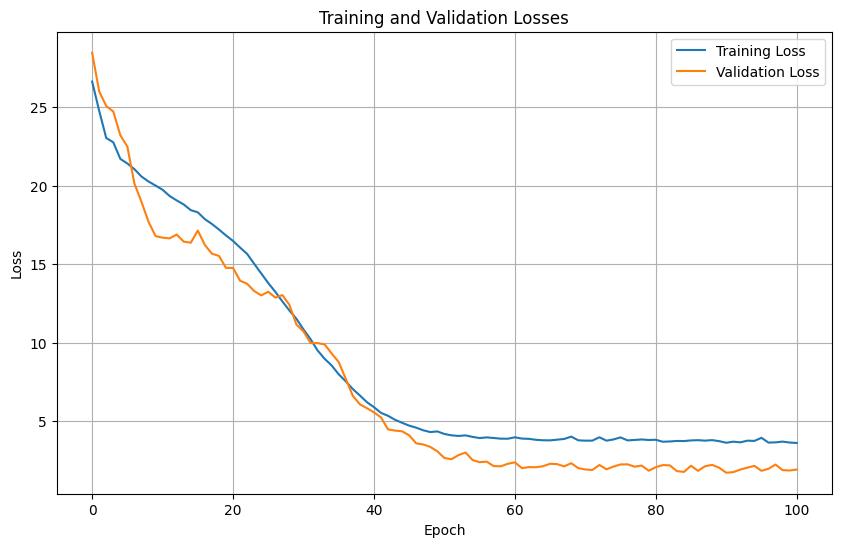

In [74]:
# Define a simple model
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Store the training and validation losses for plotting
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience=10)

# Training loop
epochs = 10000
for epoch in range(epochs):
    # Training step
    model.train()
    train_loss = 0.0
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = loss_fn(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_features.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    for batch_features, batch_labels in validation_loader:
        with torch.no_grad():
            outputs = model(batch_features)
            val_loss += loss_fn(outputs, batch_labels).item() * batch_features.size(0)
    val_loss /= len(validation_loader.dataset)
    val_losses.append(val_loss)
    
    # Print epoch information
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()


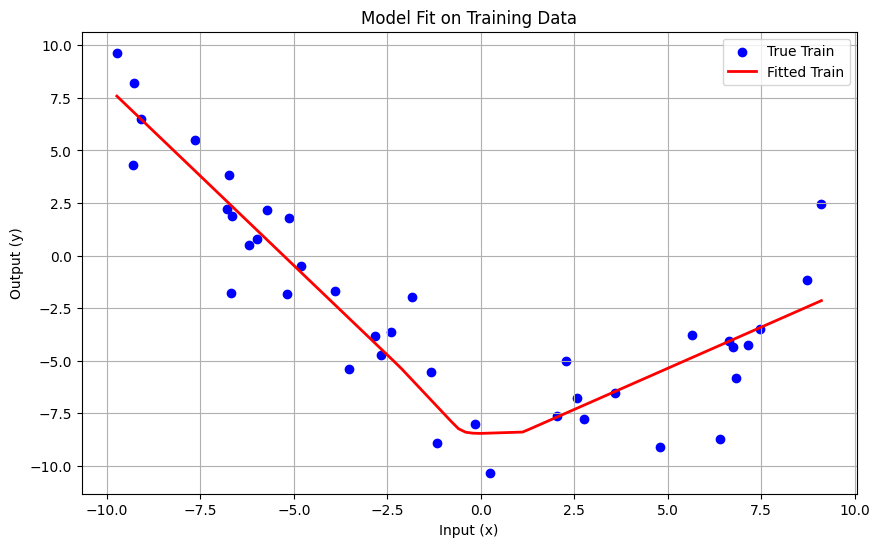

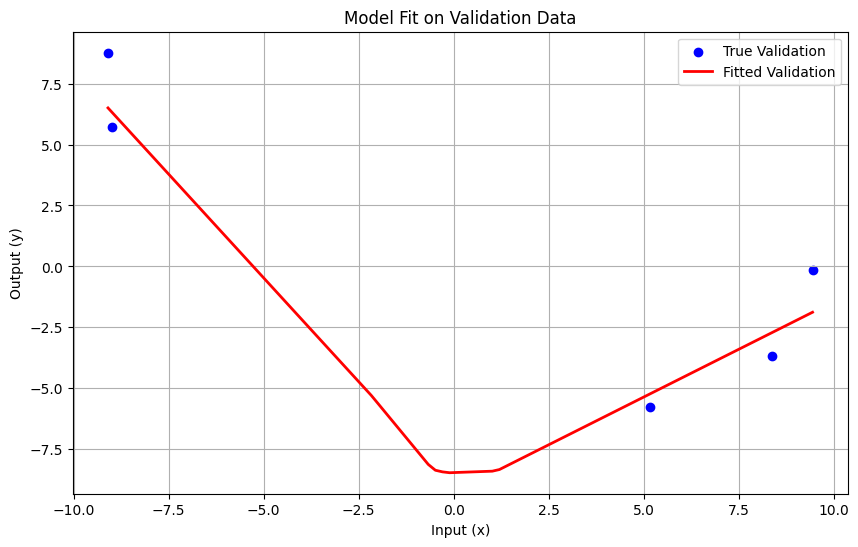

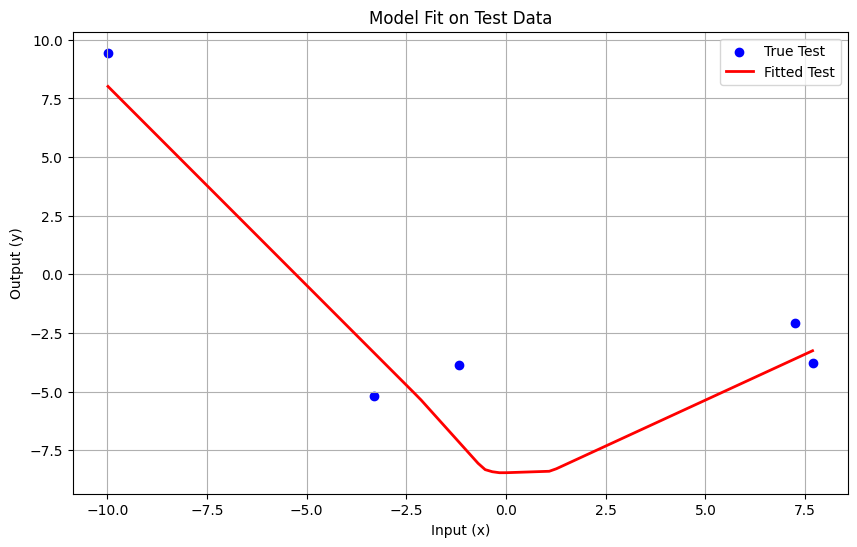

In [75]:
# Plot the model's fit as a continuous curve
def plot_model_fit(xs, ys, title, dataset_name="Dataset"):
    model.eval()  # Set the model to evaluation mode
    # Generate a range of values for x to plot the smooth curve
    x_range = torch.linspace(xs.min(), xs.max(), 100).view(-1, 1)  # 100 points for smoothness
    with torch.no_grad():
        y_range = model(x_range)  # Get predictions for the entire x_range

    # Plotting the actual data points and the model's fit
    plt.figure(figsize=(10, 6))
    plt.scatter(xs.numpy(), ys.numpy(), label=f"True {dataset_name}", color="blue")  # Original data points
    plt.plot(x_range.numpy(), y_range.numpy(), label=f"Fitted {dataset_name}", color="red", lw=2)  # Model fit line
    plt.xlabel("Input (x)")
    plt.ylabel("Output (y)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the model's fit on the training, validation, and test data
plot_model_fit(xs_train, ys_train, "Model Fit on Training Data", "Train")
plot_model_fit(xs_validation, ys_validation, "Model Fit on Validation Data", "Validation")
plot_model_fit(xs_test, ys_test, "Model Fit on Test Data", "Test")


7.4 More data

Repeat the exercise with larger datasets.

Exercise 54

8.1 Fitting a pair-potential

The purpose of this exercise is to demonstrate how the interatomic interaction can be recovered for a large datset, where only total energies for cluster of atoms are known.

8.2 The dataset

A dataset has been prepared and can be downloaded from BB.

Load the dataset and inspect the first element:

In [78]:
data_flat = np.loadtxt('pos_e1_e2_e3_1000.txt')
data_flat[0]

array([  5.055454,   4.291927,   4.100563,   2.266553,   4.693256,
         5.853959,   4.157208,   7.436068,   4.908682,   6.813956,
         5.612765,   6.151167,   6.329216,   5.468951,   6.029016,
         4.512863,   5.38903 ,   5.203717,   6.68344 ,   3.807901,
         3.956929,   6.478274,   3.789781,   5.511435, -34.298077,
       -32.365418, -33.880081])

Each line in the file contains 12 (x,y positions for atoms in an atomic cluster, and three energies calculated with three different methods.

The data becomes more accessible when reshaped like this:

In [79]:
data_in_file = [[d[:24].reshape(12,2),d[24],d[25],d[26]] for d in data_flat]
data_in_file[0]

[array([[5.055454, 4.291927],
        [4.100563, 2.266553],
        [4.693256, 5.853959],
        [4.157208, 7.436068],
        [4.908682, 6.813956],
        [5.612765, 6.151167],
        [6.329216, 5.468951],
        [6.029016, 4.512863],
        [5.38903 , 5.203717],
        [6.68344 , 3.807901],
        [3.956929, 6.478274],
        [3.789781, 5.511435]]),
 np.float64(-34.298077),
 np.float64(-32.365418),
 np.float64(-33.880081)]

Plot the data to make sure you handle it correctly.

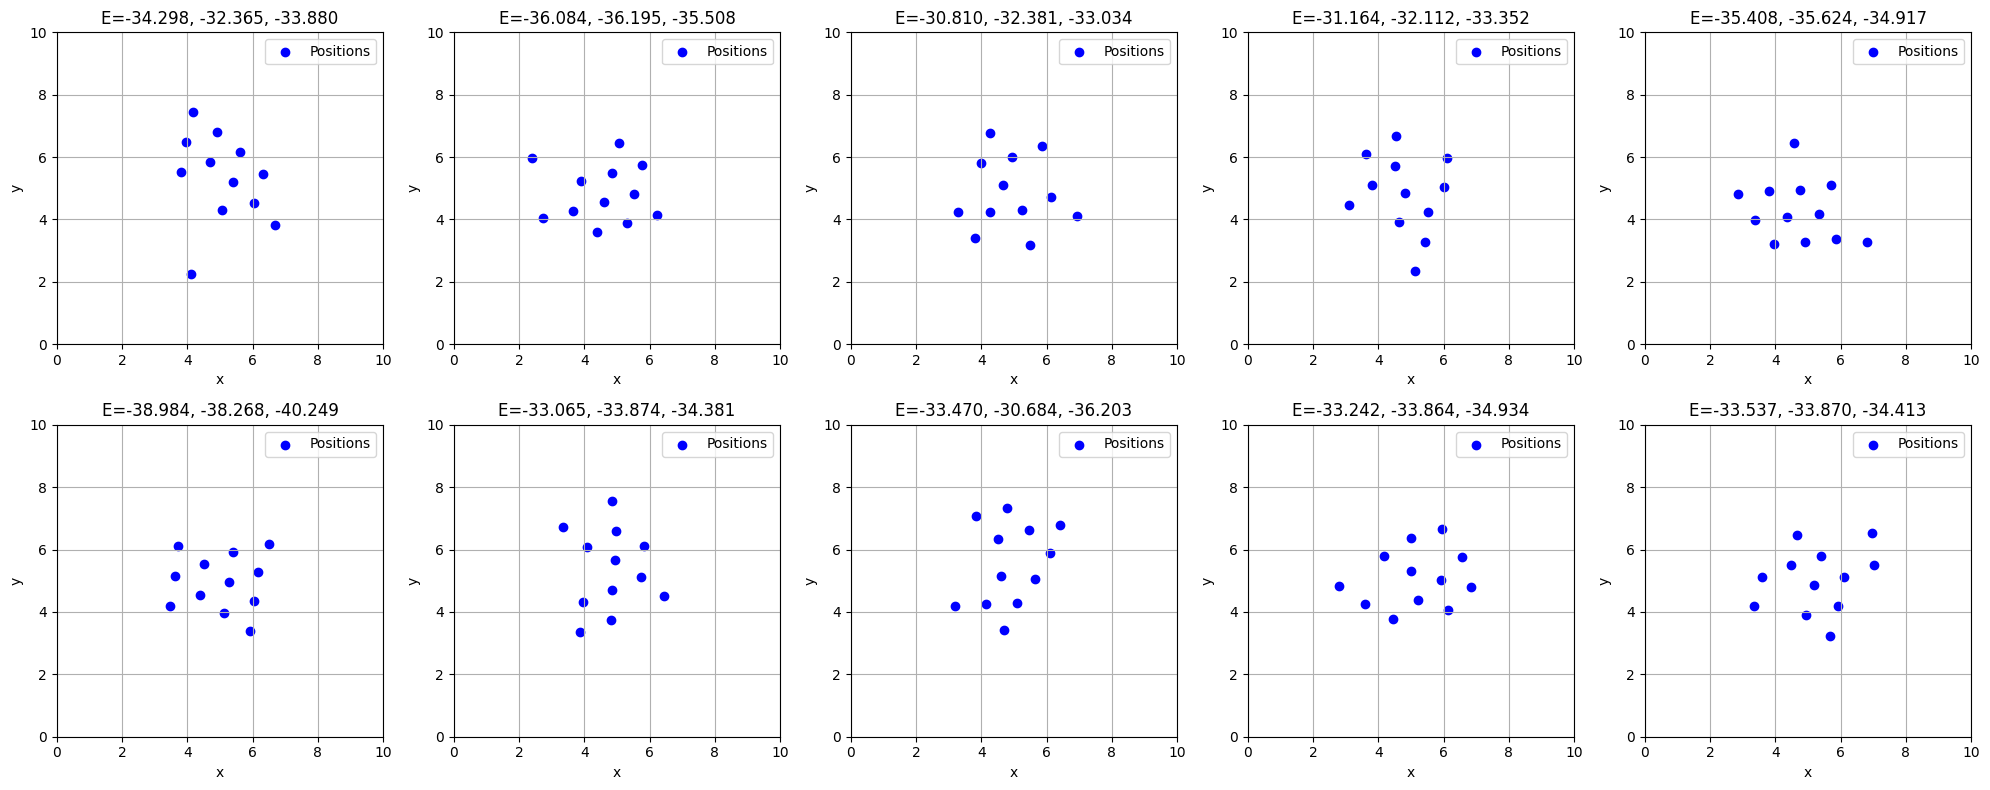

In [85]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for ax, (positions, energy1, energy2, energy3) in zip(axes.ravel(), data_in_file):
    x = positions[:, 0]  
    y = positions[:, 1]  
    
    ax.scatter(x, y, c="blue", label="Positions")
    ax.grid(True)
    ax.set_title(f'E={energy1:.3f}, {energy2:.3f}, {energy3:.3f}')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(0,10)
    ax.set_ylim(0,10)

    ax.legend()

plt.tight_layout()
plt.show()


8.3 Wrap the data

In order to use the data in conjunction with torch.nn.Module models, it is convenient to wrap them as Datasets and have them fed by DataLoaders.

We are provided with incomplete code (that we should complete ourselves) that achieves this. The ENERGY_LABEL parameter decides which of the three energies associated with each atomic cluster structure is used. We start by using the first energy label.

In [88]:
class ClusterDataset(Dataset):
    def __init__(self, data_from_file, label_index=1):
        # Extract data (positions) and labels
        self.data = torch.tensor(np.array([data[0] for data in data_from_file]), dtype=torch.float32)
        self.labels = torch.tensor(np.array([data[label_index] for data in data_from_file]), dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label


ENERGY_LABEL = 1

# Calculate split indices
num_samples = len(data_in_file)
train_end = int(num_samples * 0.8)
val_end = train_end + int(num_samples * 0.1)

# 80 - 10 - 10 split
dataset_train = ClusterDataset(data_in_file[:train_end], label_index=ENERGY_LABEL)
dataset_val = ClusterDataset(data_in_file[train_end:val_end], label_index=ENERGY_LABEL)
dataset_test = ClusterDataset(data_in_file[val_end:], label_index=ENERGY_LABEL)

print(len(dataset_train), len(dataset_val), len(dataset_test))

# Create DataLoaders
dataloader_train = DataLoader(dataset=dataset_train, batch_size=128, shuffle=True)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=128, shuffle=False)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=128, shuffle=False)

print(len(dataloader_train), len(dataloader_val), len(dataloader_test))


800 100 100
7 1 1


8.4 Fit with LJG

Write a torch.nn.Module model that implements this expression:

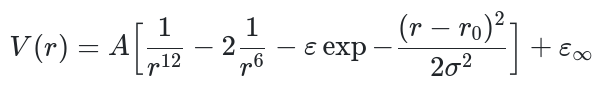

In [ ]:
class LennardJonesGauss(torch.nn.Module):
    
    def __init__(self, eps=0.5, sigma_squared=0.03, r0=1.6, eInf=0.1, A=0.9):
        super().__init__()
        self.eps = torch.nn.Parameter(torch.tensor(float(eps)))
        self.sigma_squared = torch.nn.Parameter(torch.tensor(float(sigma_squared)))
        self.r0 = torch.nn.Parameter(torch.tensor(float(r0)))
        self.eInf = torch.nn.Parameter(torch.tensor(float(eInf)))
        self.A = torch.nn.Parameter(torch.tensor(float(A)))

    def V(self, r):
    
        YOUR CODE

    def forward(self, coords):
        # loop over atomic clusters
        pairwise_distances = torch.stack([torch.pdist(coords[i]) for i in range(coords.size(0))])
        
        YOUR CODE

        return energies